In [1]:
import byxtal.lattice as gbl;
import byxtal.find_csl_dsc as fcd;
import byxtal.integer_manipulations as iman;
import byxtal.bp_basis as bpb;
import numpy as np;
import math as mt;
import gbpy.util_funcs_create_byxtal as uf
import gbpy.generate_hkl_indices as ghi

from sympy.matrices import Matrix, eye, zeros;
l1 = gbl.Lattice('Al'); l_p_po = Matrix(l1.l_p_po); l_po_p = l_p_po.inv();

In [2]:
## (h k l) indices of the fcc lattice (described in p)
h = 3
k = 4
l = 7

hkl_p = Matrix([h,k,l])
# hkl_p1
l_bpb_p = bpb.bp_basis(hkl_p)
l_bpb_p = Matrix(l_bpb_p.astype(int));
l_bpb_po = l_p_po*l_bpb_p


lat_par = l1.lat_params['a']
r_cut = lat_par*4;
A_cut = r_cut**2;
#####################################################################
### Area of the 2D unit-cell
area_bpl = (l_bpb_po[:,0].cross(l_bpb_po[:,1])).norm()
sig_num = np.ceil(A_cut/area_bpl);


#####################################################################
ind2 = np.array([], dtype='int64');
while (np.size(ind2) == 0):
    hnf_mats = ghi.sig_hnf_mats(sig_num);
    # print(hnf_mats)
    l_sig_p_mats, l_sig_po_mats = ghi.compute_hnf_props(hnf_mats, l_bpb_p, l_p_po);
    # print(l_sig_p_mats)
    ind2 = ghi.ind_min_cost(l_sig_po_mats, r_cut);
    sig_num = sig_num + 1;

l_bpbSig_p = l_sig_p_mats[ind2];
l_bpbSig_p = Matrix(l_bpbSig_p.astype(int));
l_bpbSig_po = l_p_po*l_bpbSig_p

In [3]:
l_po_go = uf.compute_orientation(l_bpbSig_po)
l2D_bpbSig_go = l_po_go*l_bpbSig_po
l2D_bpb_go = l_po_go*l_bpb_po
twoD_mat = l2D_bpb_go[:2,:]
twoDSig_mat = l2D_bpbSig_go[:2,:]
r_cut1 = uf.compute_rCut(l_bpbSig_po)
twoD_pts = uf.replicate_pts(twoD_mat, r_cut1)
twoD_pts = uf.remove_periodic_overlaps(twoD_pts, twoDSig_mat)

In [4]:
twoDSig_mat_arr = np.array(twoDSig_mat,dtype='float')
a_vec = twoDSig_mat_arr[:,0]; b_vec = twoDSig_mat_arr[:,1]

In [5]:
zCut = 25*lat_par
avec = l_bpb_p[:,0]
bvec = l_bpb_p[:,1]

l_p2_p1 = uf.find_int_solns(avec, bvec);
l_p2_po1 = (l_p_po*l_p2_p1)
l_p2_go = (l_po_go*l_p2_po1)
tz_vec = np.array(l_p2_go[:,2], dtype='double')
tz_vec = np.reshape(tz_vec, (3,))
# threeD_pts, sim_cell = uf.create_threeD_slab(zCut, tz_vec, l_bpbSig_po, twoD_pts)
# print(tz_vec)

################################################################################
## Translate 2D points in the Z-direction with zCut
num_rep = np.abs(int(np.ceil(zCut/tz_vec[2])))
num_2d = np.shape(twoD_pts)[0]
num_3d_pts = int((2*num_rep+1)*num_2d)
threeD_pts = np.zeros((num_3d_pts,3));

twoD_pts1 = np.hstack((twoD_pts, np.zeros((num_2d,1))));

for ct1 in np.arange(-num_rep, num_rep+1):
    ct2 = ct1 + num_rep;
    ind_st = (ct2)*num_2d;
    ind_stop = ind_st + num_2d;
    trans_vec = tz_vec*ct1;
    threeD_pts[ind_st:ind_stop, :] = twoD_pts1 + np.tile(trans_vec, (num_2d,1));

In [6]:
### Simulation Cell Box
### Following Ovito's convention
l_bpbSig_po_arr = np.array(l2D_bpbSig_go, dtype='double')
sim_cell = np.zeros((3,4))
sim_avec = l_bpbSig_po_arr[:,0]
sim_bvec = l_bpbSig_po_arr[:,1]

### Change this with inter-planar spacing
sim_cvec = np.array([0,0,2*zCut]); # sim_cvec = np.array([0,0,zCut]);
sim_orig = np.array([0,0,-zCut]); # sim_orig = np.array([0,0,0]);

sim_cell[:,0] = sim_avec
sim_cell[:,1] = sim_bvec
sim_cell[:,2] = sim_cvec
sim_cell[:,3] = sim_orig

box_vecs = sim_cell[:,0:3]
threeD_pts1 = uf.wrap_cc(sim_cell, threeD_pts)
# tpts1 = np.dot(np.linalg.inv(box_vecs), threeD_pts.transpose()).transpose();

In [7]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def plot_2d_pts_box(twoD_pts, twoD_mat, orig):
    ################################################################################
    l1 = np.copy(twoD_mat);
    avec = l1[:,0]; bvec=l1[:,1];
    pts = np.zeros((4,2));
    pts[0,:] = orig;
    pts[1,:] = orig+avec; pts[2,:] = orig+avec+bvec; pts[3,:] = orig+bvec;
    tinds = [0,1,2,3,0];
    x1=pts[tinds,0];y1=pts[tinds,1];
    plt.plot(x1,y1);

    pts = np.copy(twoD_pts);
    x1=pts[:,0];y1=pts[:,1];
    plt.scatter(x1,y1);
    ################################################################################

def plot_3d_pts_box(fig, pts, tmat, sim_orig):
    ################################################################################
    ax = fig.add_subplot(111, projection='3d')

    box_pts = np.zeros((8,3));
    box_pts[1,:] = tmat[:,0]; box_pts[2,:] = tmat[:,0]+tmat[:,1];
    box_pts[3,:] = tmat[:,1];
    box_pts[4,:] = box_pts[0,:]+tmat[:,2];
    box_pts[5,:] = box_pts[1,:]+tmat[:,2];
    box_pts[6,:] = box_pts[2,:]+tmat[:,2];
    box_pts[7,:] = box_pts[3,:]+tmat[:,2];
    box_pts = box_pts + sim_orig;

    tinds = [0,1,2,3,0,4,5,6,7,4,0,1,5,6,2,3,7];
    x1 = box_pts[tinds,0]; y1 = box_pts[tinds,1]; z1 = box_pts[tinds,2];
    ax.plot(x1,y1,z1);

    x1=pts[:,0];y1=pts[:,1];z1=pts[:,2];
    ax.scatter(x1,y1,z1);

    ################################################################################


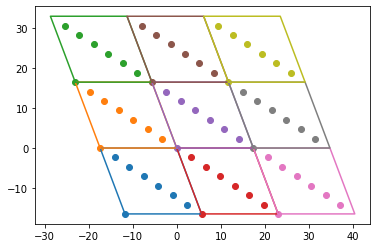

In [9]:
for tct1 in range(3):
    for tct2 in range(3):
        twoD_pts1 = 0*twoD_pts;
        orig = np.array([0,0])
        ct1 = tct1-1;
        ct2 = tct2-1;
        ct3 = 0; 
        twoD_pts1[:,ct3] = twoD_pts[:,ct3] + ct1*a_vec[ct3] + ct2*b_vec[ct3]
        ct3 = 1; 
        twoD_pts1[:,ct3] = twoD_pts[:,ct3] + ct1*a_vec[ct3] + ct2*b_vec[ct3]
        orig = ct1*a_vec + ct2*b_vec;
        plot_2d_pts_box(twoD_pts1, twoDSig_mat_arr, orig)
        # orig = ct1*a_vec + ct2*b_vec;
        # print(orig)

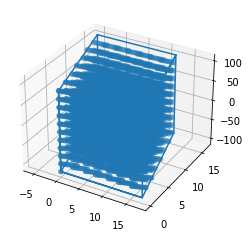

In [12]:
fig1 = plt.figure()
plot_3d_pts_box(fig1, threeD_pts1, sim_cell[:,0:3], sim_orig); plt.show();